In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.interpolate as interp
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from pycaret.regression import setup,compare_models
pd.set_option('display.max_columns', 500)

In [187]:
#We have to visulize different datasets
dengue_train_prelim_0 = pd.read_csv("dengue_features_train.csv")
dengue_test = pd.read_csv("dengue_features_test.csv")
labels_train = pd.read_csv("dengue_labels_train.csv")

In [ ]:
dengue_test.shape

In [ ]:
dengue_train_prelim_0.isna().sum(axis=1).value_counts()
dengue_train_prelim = pd.concat([dengue_train_prelim_0,labels_train['total_cases']],axis=1)
dengue_train_prelim = pd.concat([dengue_train_prelim,dengue_test],axis=0).reset_index()

In [ ]:
dengue_train_prelim

In [ ]:
dengue_train_prelim.describe()

In [ ]:
missing_values_in_rows = dengue_train_prelim.isna().sum(axis=1)
indexes = missing_values_in_rows.sort_values(ascending=False) >= 16
missing_values_in_rows.value_counts()

In [ ]:
train_1 = dengue_train_prelim.loc[indexes == False,:]
train_1.isna().sum(axis=1).sort_values(ascending=False).value_counts()

### Now have removed rows with more than 15 null values (N:10)

In [ ]:
sj_train = train_1[train_1['city'] == "sj"]
iq_train = train_1[train_1['city'] == "iq"]

In [ ]:
print(sj_train.shape)
print(iq_train.shape)

In [ ]:
## Finding the null columns: 
## Iq
iq_train.isna().sum()

In [ ]:
iq_miss_cols = ["station_avg_temp_c", "station_diur_temp_rng_c","station_max_temp_c","station_min_temp_c","station_precip_mm"]                        

In [ ]:
iq_train.head()

In [ ]:
weekly_means = iq_train.groupby('weekofyear')[iq_miss_cols].transform('mean')

# Fill the missing values with the computed means
for col in iq_miss_cols:
    iq_train[col].fillna(weekly_means[col], inplace=True)

In [ ]:
weekly_means

In [ ]:
iq_train.isna().sum()

In [ ]:
## Removing the row with 4 missing ndvi data 

iq_train_final = iq_train.loc[(iq_train.isna().sum(axis=1) == 4) == False,:]
iq_train_final.isna().sum()
iq_train.shape

### IQ city has no null values 

In [ ]:
## Null values is sj (As percentage)
sj_train.isna().sum()

In [ ]:
sj_train['ndvi_ne'].tail().sort_values()

In [ ]:
dengue_test.isna().sum(axis=1).value_counts()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of features
features = ['ndvi_se', 'ndvi_sw', 'ndvi_ne', 'ndvi_nw']

# Create a figure instance and a grid of subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

# Flatten the array of axes
axs = axs.flatten()

# Loop over each feature and plot a histogram
for i, feature in enumerate(features):
    sns.histplot(data=sj_train, x=feature, kde=True, ax=axs[i])
    axs[i].set_title(f'Histogram of {feature}')

# Adjust the layout
plt.tight_layout()
plt.show()

In [82]:
sj_null_cols = ['ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw']

In [ ]:
for col in sj_null_cols:
    sj_train[col] = sj_train[col].interpolate(method='linear')

In [ ]:
sj_train.isna().sum()

## Linear Interpolation for all NDVI values
3 missing precipitation values, removing them 

In [ ]:
sj_train_final = sj_train.loc[sj_train["precipitation_amt_mm"].isna() == False,:]

In [ ]:
sj_train_final.isna().sum()

## Done with the filling the missing values
1. Normalizing the columns, based on skewness 
2. Scaling the values 

In [90]:
## Combing the dataset
train_com_final = pd.concat(objs=(iq_train_final,sj_train_final),axis=0)
train_com_final['week_start_date'] = pd.to_datetime(train_com_final['week_start_date'], 
 format = "%Y-%m-%d",
 errors = "coerce")

In [91]:
train_com_final.sort_values(by='week_start_date',inplace=True)

In [92]:
train_com_final

,index,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4.0
1,1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5.0
2,2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4.0
3,3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3.0
4,4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1867,411,iq,2013,22,2013-05-28,0.301471,0.380029,0.280629,0.383186,41.12,297.774286,298.964286,295.638571,305.5,292.7,67.60,89.990000,41.12,17.185714,10.100000,27.400000,9.050000,32.6,21.8,33.0,NaN
1868,412,iq,2013,23,2013-06-04,0.247600,0.296343,0.285371,0.350357,71.52,297.167143,298.328571,295.845714,306.3,291.6,45.70,93.891429,71.52,17.448571,9.657143,27.520000,10.720000,33.8,21.4,68.0,NaN
1869,413,iq,2013,24,2013-06-11,0.238729,0.251029,0.252586,0.249771,78.96,295.831429,296.607143,294.894286,304.6,290.7,45.22,94.967143,78.96,16.410000,7.385714,27.200000,10.075000,32.6,21.6,93.2,NaN
1870,414,iq,2013,25,2013-06-18,0.310429,0.302700,0.406614,0.403943,39.54,295.778571,297.400000,293.648571,305.9,292.5,4.70,89.057143,39.54,15.137143,8.228571,26.700000,8.480000,32.2,21.8,34.1,NaN


### Storing the total casses seprately, will have to have its log transformation

In [93]:
train_com_final_temp = train_com_final.copy()
# Select rows where 'total_cases' is not null and only include the 'total_cases' column
target_indexed = train_com_final.loc[train_com_final['total_cases'].notna(), 'total_cases']

# Select rows where 'total_cases' is not null and drop the 'total_cases' column
train_com_final = train_com_final_temp.drop(columns='total_cases')

# Select rows where 'total_cases' is null and drop the 'total_cases' column
test_com_final = train_com_final_temp.loc[train_com_final_temp['total_cases'].isna()].drop(columns='total_cases')

In [125]:
target_indexed

0       4.0
1       5.0
2       4.0
3       3.0
4       6.0
       ... 
1451    5.0
1452    8.0
1453    1.0
1454    1.0
1455    4.0
Name: total_cases, Length: 1442, dtype: float64

In [124]:
till_train_ind = train_com_final_temp.loc[train_com_final_temp['total_cases'].notna()].drop(columns='total_cases')
till_train_ind.shape
train_com_final_temp.iloc[1442:,:]

,index,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
1512,56,sj,2009,22,2009-05-28,0.035750,0.044000,0.218157,0.186300,92.89,299.265714,299.321429,296.405714,301.2,297.4,18.30,84.414286,92.89,17.855714,2.500000,27.614286,5.714286,31.1,23.9,46.700000,NaN
1400,1400,iq,2009,23,2009-06-04,0.114000,0.092443,0.097471,0.126286,42.22,296.125714,296.778571,295.267143,302.5,292.8,53.91,95.507143,42.22,16.757143,6.071429,28.100000,11.800000,34.0,22.2,47.858333,3.0
1513,57,sj,2009,23,2009-06-04,-0.002100,0.065600,0.169471,0.168100,19.06,299.744286,299.750000,295.607143,301.9,297.3,5.22,78.308571,19.06,17.007143,2.814286,27.757143,5.800000,33.3,23.3,44.700000,NaN
1401,1401,iq,2009,24,2009-06-11,0.187129,0.157800,0.143457,0.199471,8.74,295.104286,295.778571,293.910000,305.2,289.9,112.31,94.130000,8.74,15.482857,6.242857,24.666667,8.633333,33.5,20.0,23.900000,3.0
1514,58,sj,2009,24,2009-06-11,0.018675,0.071300,0.089686,0.078200,34.18,299.560000,299.528571,295.655714,301.5,297.9,23.83,79.271429,34.18,17.038571,2.628571,27.814286,6.457143,32.2,23.9,78.700000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1867,411,iq,2013,22,2013-05-28,0.301471,0.380029,0.280629,0.383186,41.12,297.774286,298.964286,295.638571,305.5,292.7,67.60,89.990000,41.12,17.185714,10.100000,27.400000,9.050000,32.6,21.8,33.000000,NaN
1868,412,iq,2013,23,2013-06-04,0.247600,0.296343,0.285371,0.350357,71.52,297.167143,298.328571,295.845714,306.3,291.6,45.70,93.891429,71.52,17.448571,9.657143,27.520000,10.720000,33.8,21.4,68.000000,NaN
1869,413,iq,2013,24,2013-06-11,0.238729,0.251029,0.252586,0.249771,78.96,295.831429,296.607143,294.894286,304.6,290.7,45.22,94.967143,78.96,16.410000,7.385714,27.200000,10.075000,32.6,21.6,93.200000,NaN
1870,414,iq,2013,25,2013-06-18,0.310429,0.302700,0.406614,0.403943,39.54,295.778571,297.400000,293.648571,305.9,292.5,4.70,89.057143,39.54,15.137143,8.228571,26.700000,8.480000,32.2,21.8,34.100000,NaN


### Finding the skewness of data column values

In [95]:
## Finding the colums with a skewness value of more than +-0.5
## Hi
data_5 = train_com_final.copy()
skw_cols = []
skw_vals = []
for i in data_5.select_dtypes(np.number).columns:
    if(abs(stats.skew(data_5[i]))>0.5):
        print(f'Name: {i} \t Skew: {stats.skew(data_5[i])}')
        skw_cols.append(i)
        skw_vals.append(stats.skew(data_5[i]))

del(skw_cols[0:3])
del(skw_vals[0:3])

print(skw_cols)
print(skw_vals)

Name: ndvi_se 	 Skew: 0.5336589879870126
Name: ndvi_sw 	 Skew: 0.7402357932295173
Name: precipitation_amt_mm 	 Skew: 1.6796413844879006
Name: reanalysis_dew_point_temp_k 	 Skew: -0.707222992699457
Name: reanalysis_max_air_temp_k 	 Skew: 0.8138048594106753
Name: reanalysis_min_air_temp_k 	 Skew: -0.6278676049618077
Name: reanalysis_precip_amt_kg_per_m2 	 Skew: 3.0891307102003256
Name: reanalysis_relative_humidity_percent 	 Skew: 0.5627828625252771
Name: reanalysis_sat_precip_amt_mm 	 Skew: 1.6796413844879006
Name: reanalysis_specific_humidity_g_per_kg 	 Skew: -0.5386615236650463
Name: reanalysis_tdtr_k 	 Skew: 1.0244671096230398
Name: station_avg_temp_c 	 Skew: -0.5147553969532964
Name: station_diur_temp_rng_c 	 Skew: 0.7580840642678476
Name: station_precip_mm 	 Skew: 2.9623699238866488
['reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2', 'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm', 'reana

<Axes: >

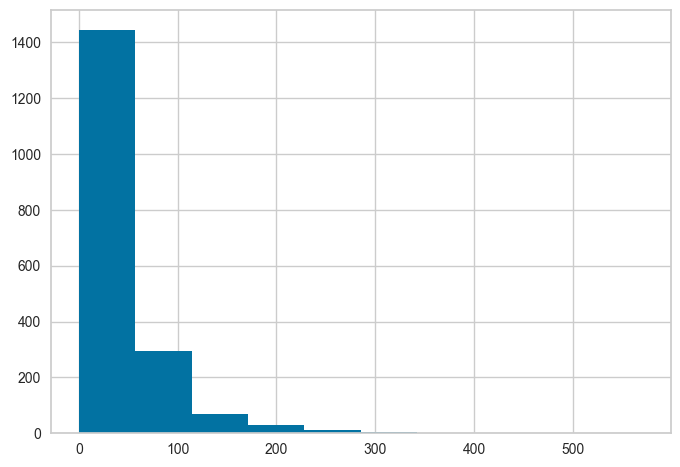

In [96]:
data_5['reanalysis_precip_amt_kg_per_m2'].hist()

In [104]:
data_5[skw_cols].describe()
zero_cols = ["precipitation_amt_mm","reanalysis_precip_amt_kg_per_m2","reanalysis_sat_precip_amt_mm",
             "station_precip_mm"]
non_zero_cols = [col for col in skw_cols if col not in zero_cols]

In [105]:
data_5.head()

,index,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [106]:
import seaborn as sns
skw_df = pd.DataFrame()
skw_df['Columns'],skw_df['Values'] = pd.DataFrame(skw_cols),pd.DataFrame(skw_vals)


In [107]:
skw_df.sort_values(by='Values',ascending=False).reset_index().drop(columns=['index'],axis=1)

,Columns,Values
0,reanalysis_precip_amt_kg_per_m2,3.089131
1,station_precip_mm,2.962370
2,reanalysis_sat_precip_amt_mm,1.679641
3,reanalysis_tdtr_k,1.024467
4,reanalysis_max_air_temp_k,0.813805
5,station_diur_temp_rng_c,0.758084
6,reanalysis_relative_humidity_percent,0.562783
7,station_avg_temp_c,-0.514755
8,reanalysis_specific_humidity_g_per_kg,-0.538662
9,reanalysis_min_air_temp_k,-0.627868


In [108]:
"""
# Iterate over each column in the dataframe
for column in skw_df['Columns']:
    # Plot histogram
    data = data_5[column]
    sns.histplot(data=d, x=column)
    
    # Get skewness value
    skewness = skw_df.loc[skw_df['Columns'] == column, 'Values'].values[0]
    
    # Set title with skewness value
    plt.title(f"Skewness: {skewness}")
    
    # Show the plot
    plt.show()
    """

'\n# Iterate over each column in the dataframe\nfor column in skw_df[\'Columns\']:\n    # Plot histogram\n    data = data_5[column]\n    sns.histplot(data=d, x=column)\n    \n    # Get skewness value\n    skewness = skw_df.loc[skw_df[\'Columns\'] == column, \'Values\'].values[0]\n    \n    # Set title with skewness value\n    plt.title(f"Skewness: {skewness}")\n    \n    # Show the plot\n    plt.show()\n    '

In [109]:
###Applying the log transform in dataframe: 
a1 = 0
a2 = 0
data_6 = data_5.copy()
aft_skw = []
for i in skw_df['Columns']:
    bc = stats.skew(data_6[i])
    print(f'Before: {bc} skeness for {i}')
    if(i in zero_cols):
        data_6[i] = np.log1p(data_6[i]) 
    else: 
        data_6[i] = np.log(data_6[i]) 
    print(f'After:{stats.skew(data_6[i])} skeness for {i} \n')
    aft_skw.append(stats.skew(data_6[i]))

skw_df["skw_after"] = pd.Series(aft_skw)

n_ele = skw_df['Columns'].shape[0]
print(f"Before: {a1} ({({a1/n_ele})}) After: {a2} ({a2/n_ele}) Total: {n_ele}")



Before: -0.707222992699457 skeness for reanalysis_dew_point_temp_k
After:-0.7176670591014049 skeness for reanalysis_dew_point_temp_k 

Before: 0.8138048594106753 skeness for reanalysis_max_air_temp_k
After:0.796184007587309 skeness for reanalysis_max_air_temp_k 

Before: -0.6278676049618077 skeness for reanalysis_min_air_temp_k
After:-0.6450453453741055 skeness for reanalysis_min_air_temp_k 

Before: 3.0891307102003256 skeness for reanalysis_precip_amt_kg_per_m2
After:-0.4373198518676707 skeness for reanalysis_precip_amt_kg_per_m2 

Before: 0.5627828625252771 skeness for reanalysis_relative_humidity_percent
After:0.39033052457520134 skeness for reanalysis_relative_humidity_percent 

Before: 1.6796413844879006 skeness for reanalysis_sat_precip_amt_mm
After:-0.9326135167333713 skeness for reanalysis_sat_precip_amt_mm 

Before: -0.5386615236650463 skeness for reanalysis_specific_humidity_g_per_kg
After:-0.7192820482877625 skeness for reanalysis_specific_humidity_g_per_kg 

Before: 1.02446

In [110]:
delta = []
## finding the percentage change
for _, row in skw_df.iterrows():
    delta.append((abs(row['skw_after'] - row['Values']) / abs(row['Values'])*100))

delta
skw_df["delta%"] = pd.DataFrame(delta)

In [111]:
skw_df.sort_values(by='Values',ascending=False).reset_index().drop('index',axis=1)

,Columns,Values,skw_after,delta%
0,reanalysis_precip_amt_kg_per_m2,3.089131,-0.437320,114.156729
1,station_precip_mm,2.962370,-0.547370,118.477428
2,reanalysis_sat_precip_amt_mm,1.679641,-0.932614,155.524562
3,reanalysis_tdtr_k,1.024467,0.582567,43.134651
4,reanalysis_max_air_temp_k,0.813805,0.796184,2.165243
5,station_diur_temp_rng_c,0.758084,0.395477,47.831990
6,reanalysis_relative_humidity_percent,0.562783,0.390331,30.642784
7,station_avg_temp_c,-0.514755,-0.630998,22.582057
8,reanalysis_specific_humidity_g_per_kg,-0.538662,-0.719282,33.531358
9,reanalysis_min_air_temp_k,-0.627868,-0.645045,2.735886


In [112]:
skw_df

,Columns,Values,skw_after,delta%
0,reanalysis_dew_point_temp_k,-0.707223,-0.717667,1.476771
1,reanalysis_max_air_temp_k,0.813805,0.796184,2.165243
2,reanalysis_min_air_temp_k,-0.627868,-0.645045,2.735886
3,reanalysis_precip_amt_kg_per_m2,3.089131,-0.437320,114.156729
4,reanalysis_relative_humidity_percent,0.562783,0.390331,30.642784
5,reanalysis_sat_precip_amt_mm,1.679641,-0.932614,155.524562
6,reanalysis_specific_humidity_g_per_kg,-0.538662,-0.719282,33.531358
7,reanalysis_tdtr_k,1.024467,0.582567,43.134651
8,station_avg_temp_c,-0.514755,-0.630998,22.582057
9,station_diur_temp_rng_c,0.758084,0.395477,47.831990


In [113]:
data_6.drop(columns=['week_start_date'],inplace=True)

In [114]:
data_7 = data_6.copy()
li = LabelEncoder()
data_7["city"]=li.fit_transform(data_7["city"])

In [115]:
data_7.isna().sum()

index                                    0
city                                     0
year                                     0
weekofyear                               0
ndvi_ne                                  0
ndvi_nw                                  0
ndvi_se                                  0
ndvi_sw                                  0
precipitation_amt_mm                     0
reanalysis_air_temp_k                    0
reanalysis_avg_temp_k                    0
reanalysis_dew_point_temp_k              0
reanalysis_max_air_temp_k                0
reanalysis_min_air_temp_k                0
reanalysis_precip_amt_kg_per_m2          0
reanalysis_relative_humidity_percent     0
reanalysis_sat_precip_amt_mm             0
reanalysis_specific_humidity_g_per_kg    0
reanalysis_tdtr_k                        0
station_avg_temp_c                       0
station_diur_temp_rng_c                  0
station_max_temp_c                       0
station_min_temp_c                       0
station_pre

In [116]:
data_5.describe()

,index,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
count,1856.000000,1856.000000,1856.000000,1856,1856.000000,1856.000000,1856.000000,1856.000000,1856.000000,1856.000000,1856.000000,1856.000000,1856.000000,1856.000000,1856.000000,1856.000000,1856.000000,1856.000000,1856.000000,1856.000000,1856.000000,1856.000000,1856.000000,1856.000000
mean,612.334052,2003.213901,26.527478,2003-09-16 04:31:33.103448192,0.128064,0.127428,0.204312,0.202211,44.101040,298.730401,299.256796,295.286847,303.476239,295.725054,40.644591,82.235258,44.101040,16.788795,4.956881,27.231329,8.066406,32.478934,22.156297,38.303876
min,0.000000,1990.000000,1.000000,1990-04-30 00:00:00,-0.463400,-0.456100,-0.015533,-0.063457,0.000000,294.554286,294.892857,289.642857,297.800000,286.200000,0.000000,57.787143,0.000000,11.715714,1.357143,21.400000,4.042857,26.700000,14.200000,0.000000
25%,235.000000,1999.000000,14.000000,1999-05-19 06:00:00,0.028875,0.040738,0.152729,0.141121,9.397500,297.681071,298.283929,294.166786,301.000000,293.800000,12.492500,77.214643,9.397500,15.592500,2.357143,26.410714,6.371429,31.100000,21.100000,8.900000
50%,520.500000,2004.000000,27.000000,2004-06-03 00:00:00,0.111346,0.111375,0.196729,0.189807,36.610000,298.625714,299.307143,295.670714,302.600000,296.200000,27.130000,80.307143,36.610000,17.143571,2.871429,27.431818,7.242857,32.800000,22.200000,24.100000
75%,986.250000,2008.000000,39.000000,2008-11-25 00:00:00,0.236997,0.219330,0.250664,0.247789,67.535000,299.891786,300.271429,296.504643,305.500000,298.000000,53.212500,86.799286,67.535000,18.030714,7.757143,28.172321,9.837500,33.900000,23.300000,51.775000
max,1455.000000,2013.000000,52.000000,2013-06-25 00:00:00,0.508357,0.649000,0.538314,0.546017,390.600000,302.200000,303.328571,298.450000,314.100000,299.900000,570.500000,98.610000,390.600000,20.461429,16.028571,30.800000,15.800000,42.200000,26.700000,543.300000
std,432.321104,6.284284,14.898083,NaN,0.142880,0.124541,0.075088,0.085568,42.075706,1.387617,1.272382,1.528062,3.205829,2.611914,44.738833,7.201837,42.075706,1.547213,3.548210,1.268631,2.221326,1.948545,1.612086,44.803494


In [117]:
## Scaling the Data: 
scaler = StandardScaler()
data_7 = scaler.fit_transform(data_7)
data_7 = pd.DataFrame(data_7,columns=data_6.columns)

In [118]:
scaler = StandardScaler()
data_7 = scaler.fit_transform(data_7)
data_7 = pd.DataFrame(data_7,columns=data_6.columns)

In [119]:
data_7

,index,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,-1.416769,0.752492,-2.103257,-0.572542,-0.038254,-0.190377,-0.077642,-0.287504,-0.753156,-0.834420,-1.190167,-1.883490,-1.153620,0.071207,0.240248,-1.282830,-0.291052,-1.850362,-0.622320,-1.414158,-0.459660,-1.580545,-1.337942,-0.179243
1,-1.414455,0.752492,-2.103257,-0.505401,0.292881,0.118441,-0.558889,-0.546209,-0.505916,-0.374103,-0.639870,-0.871934,-0.805374,0.261870,-0.282552,-0.665454,0.071249,-0.878188,-0.779984,-0.382260,-0.763147,-0.399859,0.027117,-0.638798
2,-1.412141,0.752492,-2.103257,-0.438260,-0.670772,0.365750,-0.627588,-0.366688,-0.227295,0.036783,-0.297337,0.098898,-0.931862,0.604254,0.054780,0.017688,0.323904,0.083850,-0.826822,-0.382260,-0.695448,-0.143188,0.399406,0.555736
3,-1.409828,0.752492,-2.103257,-0.371119,0.003983,0.944834,0.309658,0.393645,-0.683263,0.185073,-0.022189,0.017715,-0.647501,0.490241,-0.508453,-0.227891,-0.165970,-0.026182,-0.743518,0.209156,-0.531286,0.421487,0.709647,-1.163393
4,-1.407514,0.752492,-2.103257,-0.303979,0.477001,1.082444,0.624612,0.527542,-0.869644,0.568156,0.320343,0.351560,-0.489890,0.680199,-0.622521,-0.210132,-0.577928,0.306613,-0.412625,1.313288,0.706128,1.294168,1.081936,-0.916116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1851,-0.465830,-1.328917,1.557653,-0.303979,1.213979,2.028805,1.016638,2.115541,-0.070869,-0.689220,-0.229954,0.232263,0.637264,-1.156719,0.929289,1.090751,0.431161,0.291792,1.439211,0.154063,0.573227,0.062148,-0.221075,0.378180
1852,-0.463517,-1.328917,1.557653,-0.236838,0.836839,1.356668,1.079818,1.731784,0.651833,-1.126881,-0.729714,0.367399,0.885938,-1.581921,0.567202,1.583971,0.774240,0.451106,1.370543,0.246538,1.218093,0.678158,-0.469268,0.947343
1853,-0.461203,-1.328917,1.557653,-0.169697,0.774733,0.992719,0.643071,0.555965,0.828705,-2.089736,-2.082996,-0.254076,0.356726,-1.931009,0.557474,1.716361,0.835908,-0.192967,0.959873,-0.000966,0.981793,0.062148,-0.345172,1.197699
1854,-0.458889,-1.328917,1.557653,-0.102556,1.276687,1.407727,2.694928,2.358187,-0.108430,-2.127839,-1.459700,-1.070817,0.761683,-1.233910,-1.413221,0.969652,0.407019,-1.040363,1.125373,-0.393580,0.325502,-0.143188,-0.221075,0.403786


## Target Transformation

<Axes: >

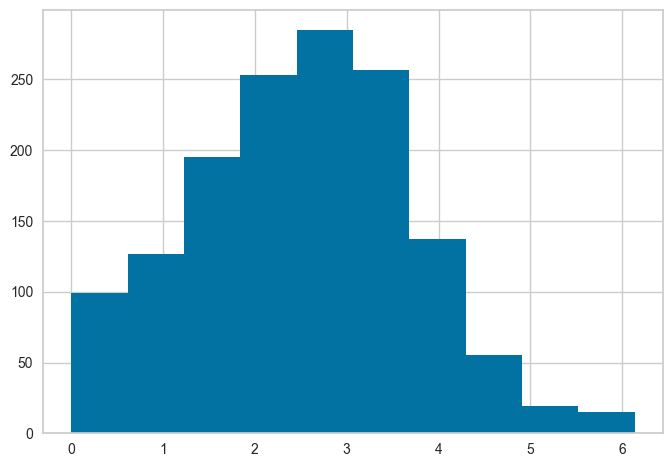

In [127]:
log_target = np.log1p(target_indexed)
# labels_train["total_cases"].describe()
stats.skew(log_target)
log_target.hist()

In [171]:
log_target.isna().sum()

0

### Splitting back to Training and Test Data Set


In [172]:
data_8 = data_7.copy()

data_8 = data_8.iloc[:1442,:]
data_8 = data_8.reset_index()


In [176]:
data_8.drop(columns=['level_0','index'],axis=1,inplace=True)

In [177]:
# log_target.drop(columns=['index'],axis=1)
log_target.reset_index().drop(columns=['index'],axis=1)

,total_cases
0,1.609438
1,1.791759
2,1.609438
3,1.386294
4,1.945910
...,...
1437,1.791759
1438,2.197225
1439,0.693147
1440,0.693147


In [185]:
data_8 = data_8.reset_index()
data_8.isna().sum(axis=1)

ValueError: cannot insert level_0, already exists

In [184]:
pd.join([data_8,log_target],axis=1)

AttributeError: module 'pandas' has no attribute 'join'

In [178]:
data_9 = pd.concat([data_8,log_target],axis=1)
data_9

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,0.752492,-2.103257,-0.572542,-0.038254,-0.190377,-0.077642,-0.287504,-0.753156,-0.834420,-1.190167,-1.883490,-1.153620,0.071207,0.240248,-1.282830,-0.291052,-1.850362,-0.622320,-1.414158,-0.459660,-1.580545,-1.337942,-0.179243,1.609438
1,0.752492,-2.103257,-0.505401,0.292881,0.118441,-0.558889,-0.546209,-0.505916,-0.374103,-0.639870,-0.871934,-0.805374,0.261870,-0.282552,-0.665454,0.071249,-0.878188,-0.779984,-0.382260,-0.763147,-0.399859,0.027117,-0.638798,1.791759
2,0.752492,-2.103257,-0.438260,-0.670772,0.365750,-0.627588,-0.366688,-0.227295,0.036783,-0.297337,0.098898,-0.931862,0.604254,0.054780,0.017688,0.323904,0.083850,-0.826822,-0.382260,-0.695448,-0.143188,0.399406,0.555736,1.609438
3,0.752492,-2.103257,-0.371119,0.003983,0.944834,0.309658,0.393645,-0.683263,0.185073,-0.022189,0.017715,-0.647501,0.490241,-0.508453,-0.227891,-0.165970,-0.026182,-0.743518,0.209156,-0.531286,0.421487,0.709647,-1.163393,1.386294
4,0.752492,-2.103257,-0.303979,0.477001,1.082444,0.624612,0.527542,-0.869644,0.568156,0.320343,0.351560,-0.489890,0.680199,-0.622521,-0.210132,-0.577928,0.306613,-0.412625,1.313288,0.706128,1.294168,1.081936,-0.916116,1.945910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.791759
1452,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.197225
1453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.693147
1454,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.693147


In [161]:
data_10 = data_9.iloc[:1442,:]
data_10.isna().sum()

level_0                                   0
index                                     0
city                                      0
year                                      0
weekofyear                                0
ndvi_ne                                   0
ndvi_nw                                   0
ndvi_se                                   0
ndvi_sw                                   0
precipitation_amt_mm                      0
reanalysis_air_temp_k                     0
reanalysis_avg_temp_k                     0
reanalysis_dew_point_temp_k               0
reanalysis_max_air_temp_k                 0
reanalysis_min_air_temp_k                 0
reanalysis_precip_amt_kg_per_m2           0
reanalysis_relative_humidity_percent      0
reanalysis_sat_precip_amt_mm              0
reanalysis_specific_humidity_g_per_kg     0
reanalysis_tdtr_k                         0
station_avg_temp_c                        0
station_diur_temp_rng_c                   0
station_max_temp_c              

In [143]:
setup(data=data_9,target='total_cases')

ValueError: 14 missing values found in the target column: total_cases. To proceed, remove the respective rows from the data. 

### Target Trasformation

In [ ]:
log_target = np.log1p(labels_train["total_cases"])
# labels_train["total_cases"].describe()
stats.skew(log_target)
log_target.hist()

In [ ]:
print(data_7.shape,log_target.shape)

In [ ]:
# pd.concat([data_7,log_target],axis=1)

In [ ]:
sj_train.columns

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size
plt.figure(figsize=(10, 6))

# Create the plot
sns.lineplot(x='week_start_date', y='total_cases', hue='city', data=dengue_train)

# Set the labels and title
plt.xlabel('Week')
plt.ylabel('Total Cases')
plt.title('Figure 1: Dengue Fever Cases by Week')

# Show the legend
plt.legend(title='City')

# Display the plot
plt.show()

In [ ]:
iq_training['week'] = iq_training['week_start_date'].dt.week

# Group by week and calculate the mean of total_cases
seasonality_data = iq_training.groupby('week')['total_cases'].mean().reset_index()

# Set the figure size
plt.figure(figsize=(10, 6))

# Create the plot
sns.lineplot(x='week', y='total_cases', data=seasonality_data)

# Set the labels and title
plt.xlabel('Weeks')
plt.ylabel('Total Cases')
plt.title('Figure 5: Seasonality of Dengue Cases, Iquitos')

# Display the plot
plt.show()

In [ ]:
missing_mask = dengue_train_prelim.isnull()

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(missing_mask, cmap='viridis', cbar=False)
plt.title('Missing Values Heatmap')
# plt.xlabel('Column Index', labelpad=10, fontsize=12, fontweight='bold')
# plt.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
plt.show()

In [ ]:
dengue_train_prelim.isna().sum().sort_values(ascending=False)

In [ ]:
dengue_train_prelim.isna().sum(axis=1).value_counts()

In [ ]:
dengue_train_prelim.isna().sum(axis=1).value_counts()

missing_values_in_rows = dengue_train_prelim.isna().sum(axis=1)
indexes = missing_values_in_rows.sort_values(ascending=False) >= 16
train_1 = dengue_train_prelim.loc[indexes == False,:]
train_1.isna().sum(axis=1).sort_values(ascending=False).value_counts()

In [ ]:
train_1

In [ ]:
dengue_train_prelim.columns